# Attention Model for DPP


For Haeyeon

Brief intro: implementation-wise, the biggest differences with most RL libraries are:
1. We use [TorchRL](https://github.com/pytorch/rl) for batched environments on GPU - tackling one of the biggest bottlenecks in RL (CPU-GPU overheads)
2. We pass states and more in the super-convenient [TensorDicts](https://github.com/pytorch-labs/tensordict)
3. Training is done in [PyTorch Lightning](https://github.com/Lightning-AI/lightning), which takes care of multiple devices, logging, checkpointing, etc.
4. We use [Hydra](https://hydra.cc/) for configuration management
5. Code is made to be as modular as possible and implemented with the latest DL advances as [FlashAttention](https://github.com/HazyResearch/flash-attention)


This should allow for easy, fast, and scalable experimentation in the future and we hope to become the to-go library for RL4CO research 🚀

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

import math
from typing import List, Tuple, Optional, NamedTuple, Dict, Union, Any
from einops import rearrange, repeat
from hydra.utils import instantiate
from omegaconf import OmegaConf, DictConfig

import torch
from torch import nn
from torch.utils.checkpoint import checkpoint
from torch.nn import DataParallel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L

from torchrl.envs import EnvBase
from torchrl.envs.utils import step_mdp
from tensordict import TensorDict

from rl4co.envs import DPPEnv
from rl4co.models.rl.reinforce import RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.data.dataset import TensorDictCollate, TensorDictDataset
from rl4co.models import AttentionModel, AttentionModelPolicy

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DPP Environment

We declare the environment here. This will automatically download the data 

In [2]:
env = DPPEnv()

td = env.reset(batch_size=[2])
print(td)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([2, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        first_node: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        observation: Tensor(shape=torch.Size([2, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        probe: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        reward: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2]),
    device=cpu,
    is_shared=False)


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
def get_random_actions(mask):
    # Get random actions from the mask (one per batch)
    # If mask = 1, then the action is valid
    batch_size = mask.shape[0]
    # Find the indices of all non-zero elements in the mask
    indices = torch.nonzero(mask)

    # Group the indices by batch
    grouped_indices = []
    for i in range(batch_size):
        indices_i = indices[indices[:, 0] == i, 1]
        grouped_indices.append(indices_i)

    # Randomly select one index from each batch
    random_indices = []
    for i in range(batch_size):
        if len(grouped_indices[i]) > 0:
            random_index_i = grouped_indices[i][torch.randint(high=len(grouped_indices[i]), size=(1,))].item()
        else:
            random_index_i = -1
        random_indices.append(random_index_i)

    return torch.tensor(random_indices)


In [4]:
bs = 10

td = env.reset(batch_size=[bs])

actions = []
probes = td['probe'].clone()
keepouts = td['action_mask'].clone() # this includes also the probes + decaps placed later

for i in range(20):
    # pick random action from action_mask
    action = get_random_actions(td['action_mask'])
    actions.append(action)
    td.set('action', action)
    td = env.step(td)['next']

actions = torch.stack(actions, dim=1)

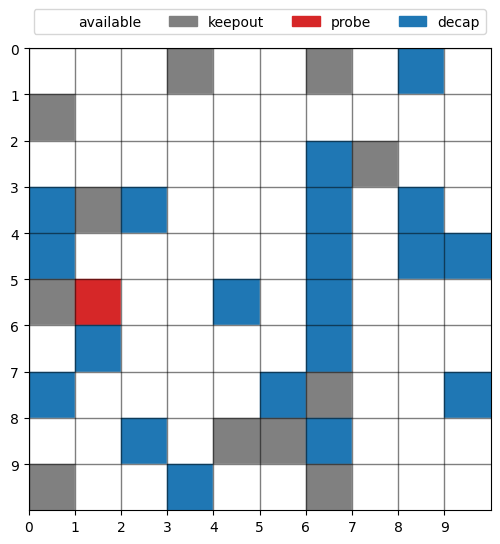

In [5]:
# Plot 
idx = 0

decaps = actions[idx]
probe = probes[idx]
action_mask = keepouts[idx]

env.render(decaps=decaps, probe=probe, action_mask=action_mask)

## Test the Policy only

In [6]:
# Load environment with test data
env = DPPEnv(val_file="test.npz", test_file="test.npz")

env.max_decaps = 20

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=TensorDictCollate(),
)

policy = AttentionModelPolicy(
    env,
).to("cuda")

# model = torch.compile(model)

td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = policy(td, decode_type="sampling")

print(out)

{'reward': tensor([10.9734,  8.8396,  8.2615,  8.1477,  8.3134,  9.5548,  8.8812, 10.5162,
         8.7323, 10.1201,  8.1642,  9.0062,  8.0499, 10.6368,  8.1448,  7.7261,
        10.4297,  8.4402, 10.0991, 11.2945,  7.4878, 10.2588,  9.0679,  9.2328,
         8.9122,  9.6644,  8.8363, 12.5638,  7.8342,  8.6039, 11.2480, 11.8206,
         9.0415,  8.8427,  8.7788,  8.1565,  9.2179,  9.3166, 13.3403,  9.0354,
         7.3999,  7.6417,  7.3047,  9.4100, 10.9441,  9.1638, 11.8015,  9.1113,
         8.2877,  9.0338, 10.4985,  8.5326, 10.2609,  8.3960, 10.6323, 10.1306,
        10.2823, 10.5400, 10.8703, 11.0823,  8.2848, 10.7789,  9.7152,  7.2053],
       device='cuda:0', dtype=torch.float64), 'log_likelihood': tensor([-80.8506, -85.4803, -76.5794, -70.9204, -88.2468, -83.8567, -70.8213,
        -80.1424, -82.2089, -71.6189, -77.7488, -75.2615, -75.1177, -79.8459,
        -71.9893, -60.1138, -77.4203, -67.6430, -86.1106, -85.2521, -73.7890,
        -78.3472, -74.6575, -86.9463, -79.4057, -7

## Create full AM: `env` + `policy` + `baseline`

In [7]:
baseline = WarmupBaseline(RolloutBaseline())

model = AttentionModel(
    env,
    policy,
    baseline=baseline,
).to("cuda")


td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([10.1005,  8.8383,  8.3361,  8.0232, 12.4502,  9.3985,  9.0394, 10.5626,
         8.8279,  9.1744,  8.5172,  9.2256, 10.8052,  9.3925,  7.6574,  7.6402,
        10.4755,  8.0688,  9.7476, 10.3776, 10.7948,  9.1889,  9.9695,  9.0297,
         9.9736, 10.5810,  8.3871, 13.5145,  8.1353,  8.8916,  8.9521,  7.4077,
         9.9856,  9.5367,  9.0044,  8.1296,  9.9611, 12.0218,  6.7422, 10.0414,
         6.7848, 10.6677,  7.2306,  9.4081, 10.7250,  8.6847,  9.7860, 10.0327,
         8.1823,  8.1488,  5.2712,  9.8065, 11.1605,  8.5153, 10.3684, 10.2567,
        10.5851, 10.7823,  8.1349, 11.0022, 10.5436, 10.7680,  8.5707,  7.6659],
       device='cuda:0', dtype=torch.float64), 'log_likelihood': tensor([-84.6108, -88.2835, -80.9344, -72.6846, -88.1485, -84.6180, -78.0383,
        -80.8608, -80.8995, -79.4208, -79.0325, -74.3564, -75.0567, -79.5292,
        -64.5618, -58.9889, -76.4329, -63.1169, -85.0714, -87.0348, -72.8023,
        -76.1518, -72.5059, -85.0313, -80.1075, -7

## Lightning Module

In [8]:
class RL4COLitModule(L.LightningModule):
    def __init__(self, env, model, cfg):
        """
        Base LightningModule for Neural Combinatorial Optimization
        If model_cfg is passed, it will take precedence over cfg.model
        Likewise for env_cfg
        
        NOTE: simplified not to use Hydra instantiate here
        """

        super().__init__()
        # this line ensures params passed to LightningModule will be saved to ckpt
        # it also allows to access params with 'self.hparams' attribute
        self.save_hyperparameters(cfg)
        self.cfg = cfg
        self.env = env
        self.model = model
        self.instantiate_metrics()

    def instantiate_metrics(self):
        """Dictionary of metrics to be logged at each phase"""
        self.train_metrics = self.cfg.metrics.get("train", ["loss", "reward"])
        self.val_metrics = self.cfg.metrics.get("val", ["reward"])
        self.test_metrics = self.cfg.metrics.get("test", ["reward"])
        self.log_on_step = self.cfg.metrics.get("log_on_step", True)


    def setup(self, stage="fit"):
        self.train_dataset = self.env.dataset(self.cfg.data.train_size, "train")
        self.val_dataset = self.env.dataset(self.cfg.data.val_size, "val")
        test_size = self.cfg.data.get("test_size", self.cfg.data.val_size)
        self.test_dataset = self.env.dataset(test_size, "test")
        if hasattr(self.model, "setup"):
            self.model.setup(self)

    def configure_optimizers(self):
        parameters = (
            self.parameters()
        )  # this will train task specific parameters such as Retrieval head for AAN
        optimizer = torch.optim.Adam(
            parameters, lr=self.cfg.optim.lr, weight_decay=self.cfg.optim.weight_decay
        )
        return [optimizer] # NOTE: for simplicity we do not include the scheduler here
    
    def shared_step(self, batch: Any, batch_idx: int, phase: str):
        td = self.env.reset(batch)
        out = self.model(td, phase)
        # Log metrics
        metrics = getattr(self, f"{phase}_metrics")
        metrics = {f"{phase}/{k}": v.mean() for k, v in out.items() if k in metrics}
        self.log_dict(
            metrics,
            on_step=self.log_on_step,
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
        )

        return {"loss": out.get("loss", None)}

    def training_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="train")

    def validation_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="val")

    def test_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="test")

    def train_dataloader(self):
        return self._dataloader(self.train_dataset)

    def val_dataloader(self):
        return self._dataloader(self.val_dataset)
    
    def test_dataloader(self):
        return self._dataloader(self.test_dataset)

    def on_train_epoch_end(self):
        if hasattr(self.model, "on_train_epoch_end"):
            self.model.on_train_epoch_end(self)
        self.train_dataset = self.env.dataset(self.cfg.data.train_size, "train")

    def _dataloader(self, dataset):
        return DataLoader(
            dataset,
            batch_size=self.cfg.data.batch_size,
            shuffle=False,  # no need to shuffle, we're resampling every epoch
            num_workers=self.cfg.data.get("num_workers", 0),
            collate_fn=TensorDictCollate(),
        )


## Main training setup

In [9]:
config = DictConfig(
    {
        "data": {
            "train_size": 1000, # with 1 epochs, this is 1k samples
            "val_size": 100, 
            "batch_size": 64,
        },
        "optim": {
            "lr": 1e-3,
            "weight_decay": 1e-3,
        },
        "metrics": {
            "train": ["loss", "reward"],
            "val": ["reward"],
            "test": ["reward"],
            "log_on_step": True,
        },
        
    }
)


lit_module = RL4COLitModule(env, model, config)

## Fit model

In [10]:
# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Trainer
trainer = L.Trainer(
    max_epochs=1, # 10
    accelerator="gpu",
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle casting to float16
    log_every_n_steps=1,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients!
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | env   | DPPEnv         | 0     
1 | model | AttentionModel | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)
2023-05-04 02:15:41.330906: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 02:15:41.349573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruc

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s, v_num=18, train/reward_step=12.40, train/loss_step=5.260, val/reward_step=12.70, val/reward_epoch=12.80, train/reward_epoch=11.80, train/loss_epoch=38.70]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s, v_num=18, train/reward_step=12.40, train/loss_step=5.260, val/reward_step=12.70, val/reward_epoch=12.80, train/reward_epoch=11.80, train/loss_epoch=38.70]


In [11]:
trainer.test(lit_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/reward_epoch     │     12.77396211205219     │
└───────────────────────────┴───────────────────────────┘

[{'test/reward_epoch': 12.77396211205219}]

## Analyze results

In [14]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")

batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy")
out['reward'].mean()

tensor(12.6795, device='cuda:0', dtype=torch.float64)

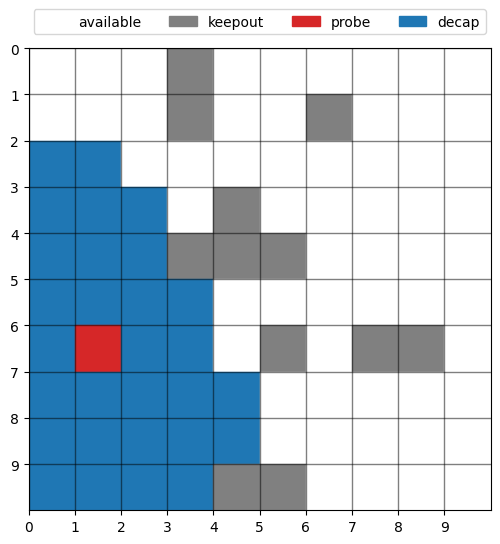

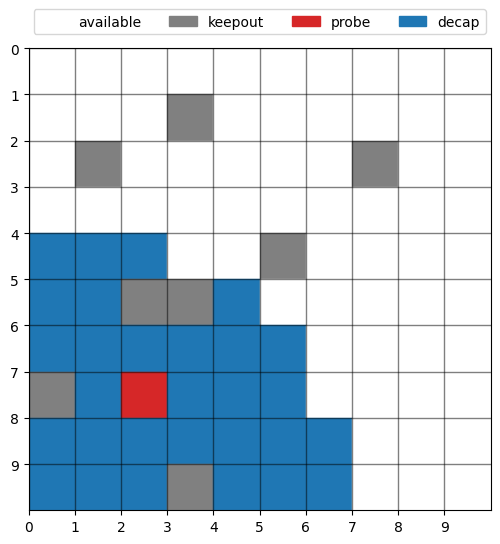

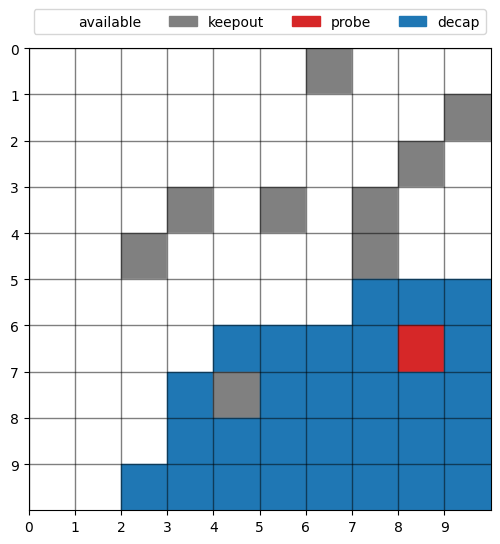

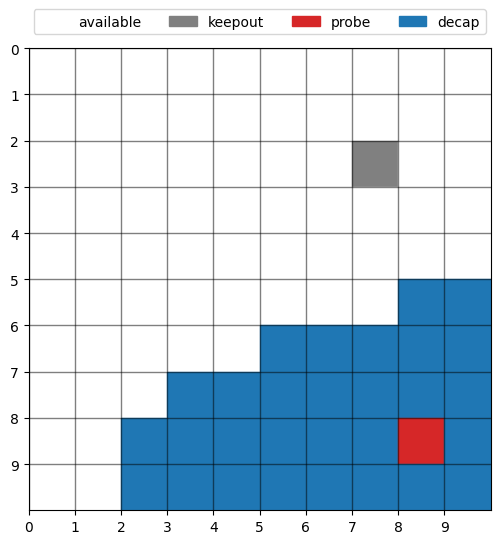

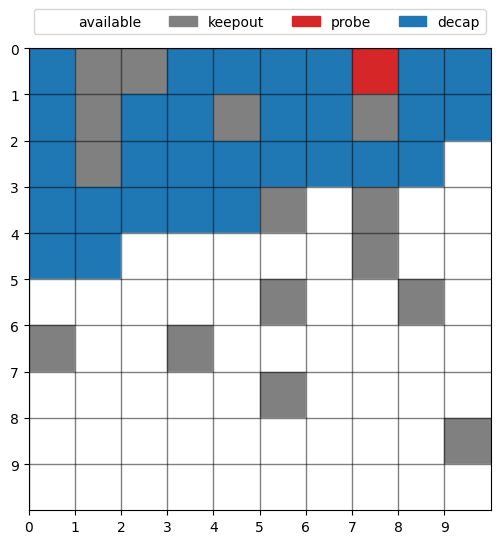

In [24]:
## Plot
import matplotlib.pyplot as plt

td = env.reset(batch).to("cuda")
probes = td['probe'].clone().cpu()
keepouts = td['action_mask'].clone().cpu()

out = policy(td, decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(5):
    env.render(decaps[i], probes[i], keepouts[i])


## Num decaps vs. reward

In [25]:
from tqdm.auto import tqdm

# Test the model with different number of actions
reward_list = []


for num_decaps in tqdm(range(1, 30)):

    batch = next(iter(dl))
    td = env.reset(batch).to("cuda")
    policy.decoder.env.max_decaps = num_decaps
    out = policy(td, decode_type="greedy")
    reward_list.append(out['reward'].mean().item())

100%|██████████| 29/29 [00:15<00:00,  1.83it/s]


Text(0, 0.5, 'Score')

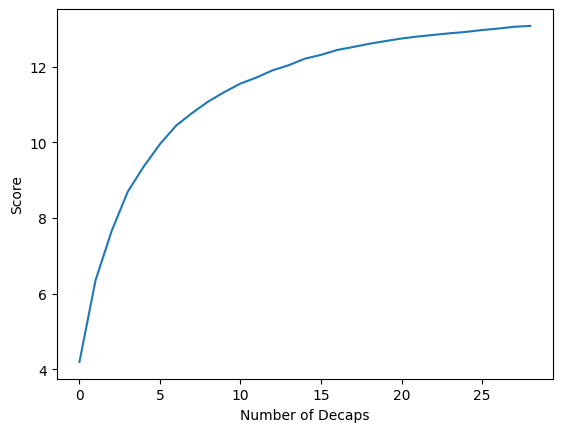

In [26]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(reward_list)
plt.xlabel("Number of Decaps")
plt.ylabel("Score")